In [1]:
#Imports
import logging
import os, random, time, sys
import numpy as np
import tensorflow as tf
import tensorflow.contrib.layers as layers
import ipdb
import keras
import pandas as pd

sys.path.append('../../../')
import feedforward_robust as ffr

sys.path.append('../../../utils/')
from utils.mnist_corruption import *
from utils.utils_models import *
from utils.utils_analysis import *
from utils.utils_feedforward import *

%load_ext autoreload
%autoreload 2

#Read the counter
ctr_file = "../../counter.txt"
f = open(ctr_file, 'r')
counter = f.readline()
f.close()

counter = 1 + int(counter)
f = open(ctr_file,'w')
f.write('{}'.format(counter))
f.close()
logfile = "../../logs/results_" + str(counter) + ".log"

logger = logging.getLogger("robustness")
logger.setLevel(logging.DEBUG)
fh = logging.FileHandler(logfile)
fh.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
logger.addHandler(fh)
logger.addHandler(logging.StreamHandler())

Using TensorFlow backend.
W0706 15:58:53.489162 4565618112 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/cleverhans/utils_tf.py:341: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.



# Get Raw Training Data

In [2]:
n = 8
n_test = 10000
x_train = np.linspace(-1, 1-(2)/n, n).astype(np.float64)
x_test = np.linspace(-1, 1-(2)/n_test, n_test).astype(np.float64)
x_train = x_train.reshape((n, 1))
x_test = x_test.reshape((n_test, 1))

In [3]:
y_train = np.sign(x_train).astype(np.int)
y_train[y_train==0] = 1
y_train_ogi = y_train.copy()
y_train[y_train==-1] = 0

y_test = np.sign(x_test).astype(np.int)
y_test[y_test==0] = 1
y_test[y_test==-1] = 0

In [4]:
y_train = y_train.flatten()
y_test = y_test.flatten()

In [5]:
num_classes = 2
y_train = keras.utils.to_categorical(y_train, num_classes)                                                                                         
y_test = keras.utils.to_categorical(y_test, num_classes)

In [6]:
y_train

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [7]:
y_test[:10]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [8]:
y_test[-10:]

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [9]:
def featurize_fourier(X, params_dict, seed=None, p = 0):
    d = params_dict['d']
    p = p/2.
    assert (d-1) % 2 == 0, "d must be odd"
    
    max_r = int((d-1)/2)
    n = len(X)
    A = np.zeros((n, d))
    A[:,0] = 1*(1/np.sqrt(2))
    
    for d_ in range(1,max_r+1):
        A[:,2*(d_-1)+1] = (1./(d_**(p/2))) * np.sin(d_*X*np.pi)
        A[:,2*(d_-1)+2] = (1./(d_**(p/2))) * np.cos(d_*X*np.pi)
    return A

In [10]:
params_dict = {}
params_dict['d'] = 101

In [11]:
phi_x_train = featurize_fourier(x_train.flatten(), params_dict, p = 2.0)
phi_x_test = featurize_fourier(x_test.flatten(), params_dict, p = 2.0)

In [12]:
phi_x_train[5]

array([ 7.07106781e-01,  7.07106781e-01,  7.07106781e-01,  7.07106781e-01,
        4.32978028e-17,  4.08248290e-01, -4.08248290e-01,  6.12323400e-17,
       -5.00000000e-01, -3.16227766e-01, -3.16227766e-01, -4.08248290e-01,
       -7.49939943e-17, -2.67261242e-01,  2.67261242e-01, -8.65956056e-17,
        3.53553391e-01,  2.35702260e-01,  2.35702260e-01,  3.16227766e-01,
        9.68168304e-17,  2.13200716e-01, -2.13200716e-01,  1.06057524e-16,
       -2.88675135e-01, -1.96116135e-01, -1.96116135e-01, -2.67261242e-01,
       -1.14555219e-16, -1.82574186e-01,  1.82574186e-01, -1.22464680e-16,
        2.50000000e-01,  1.71498585e-01,  1.71498585e-01,  2.35702260e-01,
        1.29893408e-16,  1.62221421e-01, -1.62221421e-01,  1.36919675e-16,
       -2.23606798e-01, -1.54303350e-01, -1.54303350e-01, -2.13200716e-01,
       -5.22323117e-16, -1.47441956e-01,  1.47441956e-01, -1.49987989e-16,
        2.04124145e-01,  1.41421356e-01,  1.41421356e-01,  1.96116135e-01,
       -1.92259790e-16,  

# Train neural network

In [13]:
#Configurations
eps_train = None                                                                                                                            
eps_test = None 
pgd_eta, pgd_num_iter = 1e-2, 50
tensorboard_dir = "../tb/"                                                                                                                
weights_dir = "../weights/"
load_weights = False                                                                                                              
load_counter = None                                                                                                            
input_shape = (params_dict['d'],)


sigma = tf.nn.relu 
epochs, reg, lr, batch_size = 1000, 0.00, 3e-4, n # Will have to experiment with learning rate a bit.                                                                                              


In [14]:
#Setup - Dataset stuff
tf.reset_default_graph()
sess = tf.Session()
hidden_sizes = [64, 64, 5]
dataset = ((phi_x_train, y_train), (phi_x_test, y_test))

scope_name = "visualize_one_dim"
if not load_weights:
    with tf.variable_scope(scope_name, reuse = False) as scope:

        logdir = tensorboard_dir + str(counter)

        #Create model
        writer = tf.summary.FileWriter(logdir)
        model = ffr.RobustMLP(input_shape, hidden_sizes, num_classes, writer = writer, scope = scope_name, logger = logger, sigma = sigma)
        sess.run(tf.global_variables_initializer())
        print("Created model successfully. Now going to train")
    
        #Train model
        returned = model.fit(sess, phi_x_train, y_train, training_epochs = epochs, reg_op = reg , lr = lr, batch_size = batch_size, x_test = phi_x_test)
        
        preds_list, feat_list = returned[0], returned[1]
        
        cross_loss, cross_acc = model.evaluate(sess, phi_x_test, y_test)
        print("----Regular loss and accuracy ----")
        print((cross_loss, cross_acc))
        
        
        #featurization = model.get_featurizations(sess, x_test)
        """
        #cross_margins = model.get_pointwise_margin(sess, x_train, y_train)
        cross_weight_norms = model.get_weight_norms(sess)
        print("----- Weight norms ----")
        print(cross_weight_norms)
        
        #Test model - regular, fgsm adv, pgd adv

        
        cross_confidences = model.get_prediction(sess, x_test_flat)
        
        cross_spectral = model.get_spectral_norm(sess)
        """

Initialized instance variables of the robust model class
I0706 15:58:54.592463 4565618112 feedforward_robust.py:32] Initialized instance variables of the robust model class
W0706 15:58:54.593453 4565618112 deprecation_wrapper.py:119] From ../../../feedforward_robust.py:36: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

Created placeholders for x and y
I0706 15:58:54.601720 4565618112 feedforward_robust.py:40] Created placeholders for x and y
W0706 15:58:54.604556 4565618112 deprecation_wrapper.py:119] From ../../../utils/utils_feedforward.py:34: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0706 15:58:54.606581 4565618112 deprecation_wrapper.py:119] From ../../../utils/utils_feedforward.py:34: The name tf.AUTO_REUSE is deprecated. Please use tf.compat.v1.AUTO_REUSE instead.

W0706 15:58:54.608416 4565618112 deprecation_wrapper.py:119] From ../../../utils/utils_feedforward.py:36: The name tf.get_variable

Created model successfully. Now going to train


W0706 15:58:55.495275 4565618112 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow/python/util/tf_should_use.py:193: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
Epoch: 0001    cost: 0.678474128 
I0706 15:58:55.816593 4565618112 feedforward_robust.py:751] Epoch: 0001    cost: 0.678474128 
Accuracy on batch: 0.500000
I0706 15:58:55.818411 4565618112 feedforward_robust.py:752] Accuracy on batch: 0.500000
Epoch: 0002    cost: 0.668248177 
I0706 15:58:55.839332 4565618112 feedforward_robust.py:751] Epoch: 0002    cost: 0.668248177 
Accuracy on batch: 0.625000
I0706 15:58:55.841557 4565618112 feedforward_robust.py:752] Accuracy on batch: 0.625000
Epoch: 0003    cost: 0.658237100 
I0706 15:58:55.865562 4565618112 feedforward_robust.py:751] Epoch: 0003    cost: 0.658237100 
Accuracy on batch: 0.625000
I0706 15:58:55.866878 4565618112 fe

Accuracy on batch: 1.000000
I0706 15:58:56.604318 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0034    cost: 0.438535631 
I0706 15:58:56.624881 4565618112 feedforward_robust.py:751] Epoch: 0034    cost: 0.438535631 
Accuracy on batch: 1.000000
I0706 15:58:56.629562 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0035    cost: 0.432992786 
I0706 15:58:56.654574 4565618112 feedforward_robust.py:751] Epoch: 0035    cost: 0.432992786 
Accuracy on batch: 1.000000
I0706 15:58:56.657196 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0036    cost: 0.427422464 
I0706 15:58:56.676005 4565618112 feedforward_robust.py:751] Epoch: 0036    cost: 0.427422464 
Accuracy on batch: 1.000000
I0706 15:58:56.677620 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0037    cost: 0.421719790 
I0706 15:58:56.695472 4565618112 feedforward_robust.py:751] Epoch: 0037    cost: 0.421719790 
Accuracy on batch: 1.000

I0706 15:58:57.473788 4565618112 feedforward_robust.py:751] Epoch: 0067    cost: 0.268965572 
Accuracy on batch: 1.000000
I0706 15:58:57.476098 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0068    cost: 0.264445364 
I0706 15:58:57.493758 4565618112 feedforward_robust.py:751] Epoch: 0068    cost: 0.264445364 
Accuracy on batch: 1.000000
I0706 15:58:57.496865 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0069    cost: 0.259901613 
I0706 15:58:57.516899 4565618112 feedforward_robust.py:751] Epoch: 0069    cost: 0.259901613 
Accuracy on batch: 1.000000
I0706 15:58:57.518768 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0070    cost: 0.255364120 
I0706 15:58:57.543027 4565618112 feedforward_robust.py:751] Epoch: 0070    cost: 0.255364120 
Accuracy on batch: 1.000000
I0706 15:58:57.544454 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0071    cost: 0.250876814 
I0706 15:58:57.565264 45

Epoch: 0101    cost: 0.139878303 
I0706 15:58:58.215372 4565618112 feedforward_robust.py:751] Epoch: 0101    cost: 0.139878303 
Accuracy on batch: 1.000000
I0706 15:58:58.217205 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0102    cost: 0.136986434 
I0706 15:58:58.240927 4565618112 feedforward_robust.py:751] Epoch: 0102    cost: 0.136986434 
Accuracy on batch: 1.000000
I0706 15:58:58.242349 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0103    cost: 0.134156302 
I0706 15:58:58.260770 4565618112 feedforward_robust.py:751] Epoch: 0103    cost: 0.134156302 
Accuracy on batch: 1.000000
I0706 15:58:58.262165 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0104    cost: 0.131350785 
I0706 15:58:58.281668 4565618112 feedforward_robust.py:751] Epoch: 0104    cost: 0.131350785 
Accuracy on batch: 1.000000
I0706 15:58:58.283425 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0105    cost: 0.1

I0706 15:58:58.932893 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0135    cost: 0.067665152 
I0706 15:58:58.959290 4565618112 feedforward_robust.py:751] Epoch: 0135    cost: 0.067665152 
Accuracy on batch: 1.000000
I0706 15:58:58.961676 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0136    cost: 0.066200510 
I0706 15:58:58.982444 4565618112 feedforward_robust.py:751] Epoch: 0136    cost: 0.066200510 
Accuracy on batch: 1.000000
I0706 15:58:58.986428 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0137    cost: 0.064767420 
I0706 15:58:59.005071 4565618112 feedforward_robust.py:751] Epoch: 0137    cost: 0.064767420 
Accuracy on batch: 1.000000
I0706 15:58:59.007446 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0138    cost: 0.063360862 
I0706 15:58:59.028775 4565618112 feedforward_robust.py:751] Epoch: 0138    cost: 0.063360862 
Accuracy on batch: 1.000000
I0706 15:58:59.029897 45

Accuracy on batch: 1.000000
I0706 15:58:59.689924 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0169    cost: 0.033380538 
I0706 15:58:59.713345 4565618112 feedforward_robust.py:751] Epoch: 0169    cost: 0.033380538 
Accuracy on batch: 1.000000
I0706 15:58:59.714647 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0170    cost: 0.032753218 
I0706 15:58:59.739214 4565618112 feedforward_robust.py:751] Epoch: 0170    cost: 0.032753218 
Accuracy on batch: 1.000000
I0706 15:58:59.740581 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0171    cost: 0.032139491 
I0706 15:58:59.760751 4565618112 feedforward_robust.py:751] Epoch: 0171    cost: 0.032139491 
Accuracy on batch: 1.000000
I0706 15:58:59.762732 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0172    cost: 0.031540062 
I0706 15:58:59.780611 4565618112 feedforward_robust.py:751] Epoch: 0172    cost: 0.031540062 
Accuracy on batch: 1.000

I0706 15:59:00.413456 4565618112 feedforward_robust.py:751] Epoch: 0202    cost: 0.018796213 
Accuracy on batch: 1.000000
I0706 15:59:00.414768 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0203    cost: 0.018504389 
I0706 15:59:00.433870 4565618112 feedforward_robust.py:751] Epoch: 0203    cost: 0.018504389 
Accuracy on batch: 1.000000
I0706 15:59:00.436324 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0204    cost: 0.018219037 
I0706 15:59:00.456054 4565618112 feedforward_robust.py:751] Epoch: 0204    cost: 0.018219037 
Accuracy on batch: 1.000000
I0706 15:59:00.457410 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0205    cost: 0.017940186 
I0706 15:59:00.475120 4565618112 feedforward_robust.py:751] Epoch: 0205    cost: 0.017940186 
Accuracy on batch: 1.000000
I0706 15:59:00.477800 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0206    cost: 0.017665938 
I0706 15:59:00.505114 45

Epoch: 0236    cost: 0.011363346 
I0706 15:59:01.180895 4565618112 feedforward_robust.py:751] Epoch: 0236    cost: 0.011363346 
Accuracy on batch: 1.000000
I0706 15:59:01.183855 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0237    cost: 0.011207752 
I0706 15:59:01.201653 4565618112 feedforward_robust.py:751] Epoch: 0237    cost: 0.011207752 
Accuracy on batch: 1.000000
I0706 15:59:01.204339 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0238    cost: 0.011054814 
I0706 15:59:01.226266 4565618112 feedforward_robust.py:751] Epoch: 0238    cost: 0.011054814 
Accuracy on batch: 1.000000
I0706 15:59:01.227956 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0239    cost: 0.010904601 
I0706 15:59:01.244982 4565618112 feedforward_robust.py:751] Epoch: 0239    cost: 0.010904601 
Accuracy on batch: 1.000000
I0706 15:59:01.246937 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0240    cost: 0.0

I0706 15:59:01.930213 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0270    cost: 0.007438767 
I0706 15:59:01.954587 4565618112 feedforward_robust.py:751] Epoch: 0270    cost: 0.007438767 
Accuracy on batch: 1.000000
I0706 15:59:01.957135 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0271    cost: 0.007355580 
I0706 15:59:01.982146 4565618112 feedforward_robust.py:751] Epoch: 0271    cost: 0.007355580 
Accuracy on batch: 1.000000
I0706 15:59:01.985481 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0272    cost: 0.007274142 
I0706 15:59:02.007470 4565618112 feedforward_robust.py:751] Epoch: 0272    cost: 0.007274142 
Accuracy on batch: 1.000000
I0706 15:59:02.011313 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0273    cost: 0.007193966 
I0706 15:59:02.032582 4565618112 feedforward_robust.py:751] Epoch: 0273    cost: 0.007193966 
Accuracy on batch: 1.000000
I0706 15:59:02.035295 45

Accuracy on batch: 1.000000
I0706 15:59:02.763622 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0304    cost: 0.005261650 
I0706 15:59:02.778383 4565618112 feedforward_robust.py:751] Epoch: 0304    cost: 0.005261650 
Accuracy on batch: 1.000000
I0706 15:59:02.779514 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0305    cost: 0.005213396 
I0706 15:59:02.793637 4565618112 feedforward_robust.py:751] Epoch: 0305    cost: 0.005213396 
Accuracy on batch: 1.000000
I0706 15:59:02.795001 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0306    cost: 0.005165895 
I0706 15:59:02.809209 4565618112 feedforward_robust.py:751] Epoch: 0306    cost: 0.005165895 
Accuracy on batch: 1.000000
I0706 15:59:02.810365 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0307    cost: 0.005119234 
I0706 15:59:02.824295 4565618112 feedforward_robust.py:751] Epoch: 0307    cost: 0.005119234 
Accuracy on batch: 1.000

I0706 15:59:03.296849 4565618112 feedforward_robust.py:751] Epoch: 0337    cost: 0.003971114 
Accuracy on batch: 1.000000
I0706 15:59:03.298177 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0338    cost: 0.003939903 
I0706 15:59:03.313024 4565618112 feedforward_robust.py:751] Epoch: 0338    cost: 0.003939903 
Accuracy on batch: 1.000000
I0706 15:59:03.314628 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0339    cost: 0.003909105 
I0706 15:59:03.328521 4565618112 feedforward_robust.py:751] Epoch: 0339    cost: 0.003909105 
Accuracy on batch: 1.000000
I0706 15:59:03.330054 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0340    cost: 0.003878634 
I0706 15:59:03.344616 4565618112 feedforward_robust.py:751] Epoch: 0340    cost: 0.003878634 
Accuracy on batch: 1.000000
I0706 15:59:03.345709 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0341    cost: 0.003848547 
I0706 15:59:03.363973 45

Epoch: 0371    cost: 0.003086364 
I0706 15:59:03.971141 4565618112 feedforward_robust.py:751] Epoch: 0371    cost: 0.003086364 
Accuracy on batch: 1.000000
I0706 15:59:03.972805 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0372    cost: 0.003065069 
I0706 15:59:03.993636 4565618112 feedforward_robust.py:751] Epoch: 0372    cost: 0.003065069 
Accuracy on batch: 1.000000
I0706 15:59:03.995514 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0373    cost: 0.003043715 
I0706 15:59:04.014411 4565618112 feedforward_robust.py:751] Epoch: 0373    cost: 0.003043715 
Accuracy on batch: 1.000000
I0706 15:59:04.016376 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0374    cost: 0.003022761 
I0706 15:59:04.034690 4565618112 feedforward_robust.py:751] Epoch: 0374    cost: 0.003022761 
Accuracy on batch: 1.000000
I0706 15:59:04.035927 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0375    cost: 0.0

I0706 15:59:04.590605 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0405    cost: 0.002467956 
I0706 15:59:04.606845 4565618112 feedforward_robust.py:751] Epoch: 0405    cost: 0.002467956 
Accuracy on batch: 1.000000
I0706 15:59:04.607909 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0406    cost: 0.002452665 
I0706 15:59:04.623255 4565618112 feedforward_robust.py:751] Epoch: 0406    cost: 0.002452665 
Accuracy on batch: 1.000000
I0706 15:59:04.624401 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0407    cost: 0.002437581 
I0706 15:59:04.638904 4565618112 feedforward_robust.py:751] Epoch: 0407    cost: 0.002437581 
Accuracy on batch: 1.000000
I0706 15:59:04.640074 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0408    cost: 0.002422631 
I0706 15:59:04.655063 4565618112 feedforward_robust.py:751] Epoch: 0408    cost: 0.002422631 
Accuracy on batch: 1.000000
I0706 15:59:04.656325 45

Accuracy on batch: 1.000000
I0706 15:59:05.217797 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0439    cost: 0.002018353 
I0706 15:59:05.237808 4565618112 feedforward_robust.py:751] Epoch: 0439    cost: 0.002018353 
Accuracy on batch: 1.000000
I0706 15:59:05.248389 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0440    cost: 0.002006785 
I0706 15:59:05.274455 4565618112 feedforward_robust.py:751] Epoch: 0440    cost: 0.002006785 
Accuracy on batch: 1.000000
I0706 15:59:05.282034 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0441    cost: 0.001995337 
I0706 15:59:05.300965 4565618112 feedforward_robust.py:751] Epoch: 0441    cost: 0.001995337 
Accuracy on batch: 1.000000
I0706 15:59:05.302061 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0442    cost: 0.001983963 
I0706 15:59:05.317914 4565618112 feedforward_robust.py:751] Epoch: 0442    cost: 0.001983963 
Accuracy on batch: 1.000

I0706 15:59:05.967161 4565618112 feedforward_robust.py:751] Epoch: 0472    cost: 0.001683067 
Accuracy on batch: 1.000000
I0706 15:59:05.969419 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0473    cost: 0.001674276 
I0706 15:59:05.993533 4565618112 feedforward_robust.py:751] Epoch: 0473    cost: 0.001674276 
Accuracy on batch: 1.000000
I0706 15:59:06.002439 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0474    cost: 0.001665575 
I0706 15:59:06.024753 4565618112 feedforward_robust.py:751] Epoch: 0474    cost: 0.001665575 
Accuracy on batch: 1.000000
I0706 15:59:06.027216 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0475    cost: 0.001656904 
I0706 15:59:06.049268 4565618112 feedforward_robust.py:751] Epoch: 0475    cost: 0.001656904 
Accuracy on batch: 1.000000
I0706 15:59:06.051130 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0476    cost: 0.001648307 
I0706 15:59:06.072023 45

Epoch: 0506    cost: 0.001419264 
I0706 15:59:06.799213 4565618112 feedforward_robust.py:751] Epoch: 0506    cost: 0.001419264 
Accuracy on batch: 1.000000
I0706 15:59:06.801648 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0507    cost: 0.001412435 
I0706 15:59:06.824592 4565618112 feedforward_robust.py:751] Epoch: 0507    cost: 0.001412435 
Accuracy on batch: 1.000000
I0706 15:59:06.827008 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0508    cost: 0.001405710 
I0706 15:59:06.855773 4565618112 feedforward_robust.py:751] Epoch: 0508    cost: 0.001405710 
Accuracy on batch: 1.000000
I0706 15:59:06.857093 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0509    cost: 0.001399045 
I0706 15:59:06.880949 4565618112 feedforward_robust.py:751] Epoch: 0509    cost: 0.001399045 
Accuracy on batch: 1.000000
I0706 15:59:06.884613 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0510    cost: 0.0

I0706 15:59:07.549124 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0540    cost: 0.001212930 
I0706 15:59:07.568993 4565618112 feedforward_robust.py:751] Epoch: 0540    cost: 0.001212930 
Accuracy on batch: 1.000000
I0706 15:59:07.570234 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0541    cost: 0.001207528 
I0706 15:59:07.586642 4565618112 feedforward_robust.py:751] Epoch: 0541    cost: 0.001207528 
Accuracy on batch: 1.000000
I0706 15:59:07.588070 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0542    cost: 0.001202156 
I0706 15:59:07.604823 4565618112 feedforward_robust.py:751] Epoch: 0542    cost: 0.001202156 
Accuracy on batch: 1.000000
I0706 15:59:07.605991 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0543    cost: 0.001196829 
I0706 15:59:07.622358 4565618112 feedforward_robust.py:751] Epoch: 0543    cost: 0.001196829 
Accuracy on batch: 1.000000
I0706 15:59:07.623661 45

Accuracy on batch: 1.000000
I0706 15:59:08.174095 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0574    cost: 0.001048106 
I0706 15:59:08.188645 4565618112 feedforward_robust.py:751] Epoch: 0574    cost: 0.001048106 
Accuracy on batch: 1.000000
I0706 15:59:08.189956 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0575    cost: 0.001043760 
I0706 15:59:08.204005 4565618112 feedforward_robust.py:751] Epoch: 0575    cost: 0.001043760 
Accuracy on batch: 1.000000
I0706 15:59:08.205489 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0576    cost: 0.001039488 
I0706 15:59:08.219949 4565618112 feedforward_robust.py:751] Epoch: 0576    cost: 0.001039488 
Accuracy on batch: 1.000000
I0706 15:59:08.221629 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0577    cost: 0.001035246 
I0706 15:59:08.235852 4565618112 feedforward_robust.py:751] Epoch: 0577    cost: 0.001035246 
Accuracy on batch: 1.000

I0706 15:59:08.710513 4565618112 feedforward_robust.py:751] Epoch: 0607    cost: 0.000910318 
Accuracy on batch: 1.000000
I0706 15:59:08.713884 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0608    cost: 0.000906552 
I0706 15:59:08.732382 4565618112 feedforward_robust.py:751] Epoch: 0608    cost: 0.000906552 
Accuracy on batch: 1.000000
I0706 15:59:08.733521 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0609    cost: 0.000902756 
I0706 15:59:08.756278 4565618112 feedforward_robust.py:751] Epoch: 0609    cost: 0.000902756 
Accuracy on batch: 1.000000
I0706 15:59:08.757480 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0610    cost: 0.000898975 
I0706 15:59:08.775063 4565618112 feedforward_robust.py:751] Epoch: 0610    cost: 0.000898975 
Accuracy on batch: 1.000000
I0706 15:59:08.778659 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0611    cost: 0.000895268 
I0706 15:59:08.797451 45

Epoch: 0641    cost: 0.000790685 
I0706 15:59:09.297528 4565618112 feedforward_robust.py:751] Epoch: 0641    cost: 0.000790685 
Accuracy on batch: 1.000000
I0706 15:59:09.298846 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0642    cost: 0.000787603 
I0706 15:59:09.312840 4565618112 feedforward_robust.py:751] Epoch: 0642    cost: 0.000787603 
Accuracy on batch: 1.000000
I0706 15:59:09.314388 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0643    cost: 0.000784596 
I0706 15:59:09.329671 4565618112 feedforward_robust.py:751] Epoch: 0643    cost: 0.000784596 
Accuracy on batch: 1.000000
I0706 15:59:09.331290 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0644    cost: 0.000781588 
I0706 15:59:09.346171 4565618112 feedforward_robust.py:751] Epoch: 0644    cost: 0.000781588 
Accuracy on batch: 1.000000
I0706 15:59:09.347629 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0645    cost: 0.0

I0706 15:59:09.904159 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0675    cost: 0.000694905 
I0706 15:59:09.918657 4565618112 feedforward_robust.py:751] Epoch: 0675    cost: 0.000694905 
Accuracy on batch: 1.000000
I0706 15:59:09.919826 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0676    cost: 0.000692389 
I0706 15:59:09.934561 4565618112 feedforward_robust.py:751] Epoch: 0676    cost: 0.000692389 
Accuracy on batch: 1.000000
I0706 15:59:09.935637 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0677    cost: 0.000689843 
I0706 15:59:09.949939 4565618112 feedforward_robust.py:751] Epoch: 0677    cost: 0.000689843 
Accuracy on batch: 1.000000
I0706 15:59:09.951239 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0678    cost: 0.000687341 
I0706 15:59:09.965210 4565618112 feedforward_robust.py:751] Epoch: 0678    cost: 0.000687341 
Accuracy on batch: 1.000000
I0706 15:59:09.966301 45

Accuracy on batch: 1.000000
I0706 15:59:10.528481 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0709    cost: 0.000616761 
I0706 15:59:10.546594 4565618112 feedforward_robust.py:751] Epoch: 0709    cost: 0.000616761 
Accuracy on batch: 1.000000
I0706 15:59:10.547796 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0710    cost: 0.000614676 
I0706 15:59:10.562039 4565618112 feedforward_robust.py:751] Epoch: 0710    cost: 0.000614676 
Accuracy on batch: 1.000000
I0706 15:59:10.563244 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0711    cost: 0.000612606 
I0706 15:59:10.577323 4565618112 feedforward_robust.py:751] Epoch: 0711    cost: 0.000612606 
Accuracy on batch: 1.000000
I0706 15:59:10.578505 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0712    cost: 0.000610566 
I0706 15:59:10.591739 4565618112 feedforward_robust.py:751] Epoch: 0712    cost: 0.000610566 
Accuracy on batch: 1.000

I0706 15:59:11.093136 4565618112 feedforward_robust.py:751] Epoch: 0742    cost: 0.000553754 
Accuracy on batch: 1.000000
I0706 15:59:11.096218 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0743    cost: 0.000551982 
I0706 15:59:11.117811 4565618112 feedforward_robust.py:751] Epoch: 0743    cost: 0.000551982 
Accuracy on batch: 1.000000
I0706 15:59:11.119396 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0744    cost: 0.000550270 
I0706 15:59:11.139471 4565618112 feedforward_robust.py:751] Epoch: 0744    cost: 0.000550270 
Accuracy on batch: 1.000000
I0706 15:59:11.141324 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0745    cost: 0.000548542 
I0706 15:59:11.162032 4565618112 feedforward_robust.py:751] Epoch: 0745    cost: 0.000548542 
Accuracy on batch: 1.000000
I0706 15:59:11.165583 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0746    cost: 0.000546815 
I0706 15:59:11.185330 45

Epoch: 0776    cost: 0.000498667 
I0706 15:59:11.672265 4565618112 feedforward_robust.py:751] Epoch: 0776    cost: 0.000498667 
Accuracy on batch: 1.000000
I0706 15:59:11.673421 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0777    cost: 0.000497192 
I0706 15:59:11.688243 4565618112 feedforward_robust.py:751] Epoch: 0777    cost: 0.000497192 
Accuracy on batch: 1.000000
I0706 15:59:11.689419 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0778    cost: 0.000495703 
I0706 15:59:11.703596 4565618112 feedforward_robust.py:751] Epoch: 0778    cost: 0.000495703 
Accuracy on batch: 1.000000
I0706 15:59:11.704636 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0779    cost: 0.000494243 
I0706 15:59:11.718240 4565618112 feedforward_robust.py:751] Epoch: 0779    cost: 0.000494243 
Accuracy on batch: 1.000000
I0706 15:59:11.719357 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0780    cost: 0.0

I0706 15:59:12.284357 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0810    cost: 0.000448669 
I0706 15:59:12.299082 4565618112 feedforward_robust.py:751] Epoch: 0810    cost: 0.000448669 
Accuracy on batch: 1.000000
I0706 15:59:12.300377 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0811    cost: 0.000447180 
I0706 15:59:12.314105 4565618112 feedforward_robust.py:751] Epoch: 0811    cost: 0.000447180 
Accuracy on batch: 1.000000
I0706 15:59:12.315254 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0812    cost: 0.000445765 
I0706 15:59:12.329517 4565618112 feedforward_robust.py:751] Epoch: 0812    cost: 0.000445765 
Accuracy on batch: 1.000000
I0706 15:59:12.330770 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0813    cost: 0.000444290 
I0706 15:59:12.344772 4565618112 feedforward_robust.py:751] Epoch: 0813    cost: 0.000444290 
Accuracy on batch: 1.000000
I0706 15:59:12.346060 45

Accuracy on batch: 1.000000
I0706 15:59:12.868731 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0844    cost: 0.000403435 
I0706 15:59:12.882858 4565618112 feedforward_robust.py:751] Epoch: 0844    cost: 0.000403435 
Accuracy on batch: 1.000000
I0706 15:59:12.884022 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0845    cost: 0.000402214 
I0706 15:59:12.898132 4565618112 feedforward_robust.py:751] Epoch: 0845    cost: 0.000402214 
Accuracy on batch: 1.000000
I0706 15:59:12.899215 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0846    cost: 0.000401022 
I0706 15:59:12.913223 4565618112 feedforward_robust.py:751] Epoch: 0846    cost: 0.000401022 
Accuracy on batch: 1.000000
I0706 15:59:12.914290 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0847    cost: 0.000399845 
I0706 15:59:12.927794 4565618112 feedforward_robust.py:751] Epoch: 0847    cost: 0.000399845 
Accuracy on batch: 1.000

I0706 15:59:13.410264 4565618112 feedforward_robust.py:751] Epoch: 0877    cost: 0.000366719 
Accuracy on batch: 1.000000
I0706 15:59:13.411283 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0878    cost: 0.000365721 
I0706 15:59:13.424938 4565618112 feedforward_robust.py:751] Epoch: 0878    cost: 0.000365721 
Accuracy on batch: 1.000000
I0706 15:59:13.426114 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0879    cost: 0.000364678 
I0706 15:59:13.440277 4565618112 feedforward_robust.py:751] Epoch: 0879    cost: 0.000364678 
Accuracy on batch: 1.000000
I0706 15:59:13.441514 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0880    cost: 0.000363650 
I0706 15:59:13.455271 4565618112 feedforward_robust.py:751] Epoch: 0880    cost: 0.000363650 
Accuracy on batch: 1.000000
I0706 15:59:13.456316 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0881    cost: 0.000362637 
I0706 15:59:13.470448 45

Epoch: 0911    cost: 0.000334157 
I0706 15:59:13.922317 4565618112 feedforward_robust.py:751] Epoch: 0911    cost: 0.000334157 
Accuracy on batch: 1.000000
I0706 15:59:13.923639 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0912    cost: 0.000333263 
I0706 15:59:13.938934 4565618112 feedforward_robust.py:751] Epoch: 0912    cost: 0.000333263 
Accuracy on batch: 1.000000
I0706 15:59:13.940142 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0913    cost: 0.000332355 
I0706 15:59:13.954405 4565618112 feedforward_robust.py:751] Epoch: 0913    cost: 0.000332355 
Accuracy on batch: 1.000000
I0706 15:59:13.955545 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0914    cost: 0.000331491 
I0706 15:59:13.969102 4565618112 feedforward_robust.py:751] Epoch: 0914    cost: 0.000331491 
Accuracy on batch: 1.000000
I0706 15:59:13.970133 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0915    cost: 0.0

I0706 15:59:14.528375 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0945    cost: 0.000305661 
I0706 15:59:14.546000 4565618112 feedforward_robust.py:751] Epoch: 0945    cost: 0.000305661 
Accuracy on batch: 1.000000
I0706 15:59:14.549232 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0946    cost: 0.000304901 
I0706 15:59:14.565808 4565618112 feedforward_robust.py:751] Epoch: 0946    cost: 0.000304901 
Accuracy on batch: 1.000000
I0706 15:59:14.567053 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0947    cost: 0.000304127 
I0706 15:59:14.581593 4565618112 feedforward_robust.py:751] Epoch: 0947    cost: 0.000304127 
Accuracy on batch: 1.000000
I0706 15:59:14.582731 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0948    cost: 0.000303367 
I0706 15:59:14.597296 4565618112 feedforward_robust.py:751] Epoch: 0948    cost: 0.000303367 
Accuracy on batch: 1.000000
I0706 15:59:14.598551 45

Accuracy on batch: 1.000000
I0706 15:59:15.108114 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0979    cost: 0.000280218 
I0706 15:59:15.125094 4565618112 feedforward_robust.py:751] Epoch: 0979    cost: 0.000280218 
Accuracy on batch: 1.000000
I0706 15:59:15.126266 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0980    cost: 0.000279458 
I0706 15:59:15.142618 4565618112 feedforward_robust.py:751] Epoch: 0980    cost: 0.000279458 
Accuracy on batch: 1.000000
I0706 15:59:15.143695 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0981    cost: 0.000278698 
I0706 15:59:15.159610 4565618112 feedforward_robust.py:751] Epoch: 0981    cost: 0.000278698 
Accuracy on batch: 1.000000
I0706 15:59:15.161029 4565618112 feedforward_robust.py:752] Accuracy on batch: 1.000000
Epoch: 0982    cost: 0.000277954 
I0706 15:59:15.177420 4565618112 feedforward_robust.py:751] Epoch: 0982    cost: 0.000277954 
Accuracy on batch: 1.000

----Regular loss and accuracy ----
(0.38331732, 0.9108)


In [15]:
feat_list = np.array(feat_list)
preds_list = np.array(preds_list)

In [16]:
feat_list.shape

(1000, 10000, 5)

# Processing preds and plotting

In [17]:
def flatten_single_pred(preds_single_epoch):
    preds_new = [preds[1] - preds[0] for preds in preds_single_epoch]
    return preds_new

In [18]:
preds_list_flat = [flatten_single_pred(pse) for pse in preds_list]

In [19]:
preds_list_flat = np.array(preds_list_flat)
preds_list_flat.shape

(1000, 10000)

In [20]:
preds_means = np.mean(np.abs(preds_list_flat), axis = 1)
preds_means.shape

(1000,)

In [21]:
preds_means

array([0.12418915, 0.12297691, 0.12226594, 0.12245794, 0.12362389,
       0.12536798, 0.1275584 , 0.13023569, 0.13329531, 0.13649842,
       0.13981389, 0.14322323, 0.14675044, 0.15033019, 0.15419778,
       0.15832807, 0.16273548, 0.16743553, 0.17230247, 0.17709154,
       0.18187334, 0.18692344, 0.19218618, 0.19745381, 0.2027186 ,
       0.20812243, 0.2137496 , 0.2195838 , 0.22550659, 0.23172915,
       0.23818581, 0.2450136 , 0.25211394, 0.2593712 , 0.26642704,
       0.2732886 , 0.28019646, 0.28730848, 0.294643  , 0.30183408,
       0.30877686, 0.31574082, 0.3226517 , 0.3295009 , 0.3362819 ,
       0.34322032, 0.35029066, 0.35737324, 0.36433902, 0.3714113 ,
       0.37854597, 0.3855109 , 0.39267096, 0.40002894, 0.40749198,
       0.4150568 , 0.42261758, 0.43026954, 0.43791476, 0.4452595 ,
       0.45248327, 0.45987475, 0.46732324, 0.47498727, 0.48278412,
       0.4906575 , 0.4984348 , 0.5059326 , 0.51353437, 0.52149147,
       0.52968913, 0.53801376, 0.5461181 , 0.55408865, 0.56220

In [22]:
final_preds = preds_list_flat[-1]
final_preds.shape

(10000,)

In [23]:
indices = np.arange(0, 100, 20)

In [24]:
indices

array([ 0, 20, 40, 60, 80])

In [25]:
indices_two = np.arange(100, 1000, 100)

In [26]:
indices = np.hstack((indices, indices_two))

In [27]:
preds_list_smaller = preds_list_flat[indices]
preds_list_smaller.shape

(14, 10000)

In [28]:
x_train.shape

(8, 1)

In [29]:
y_train_ogi.shape

(8, 1)

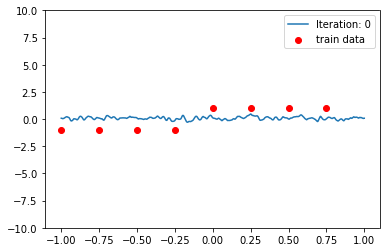

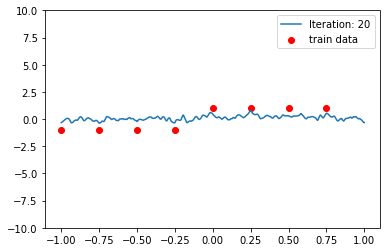

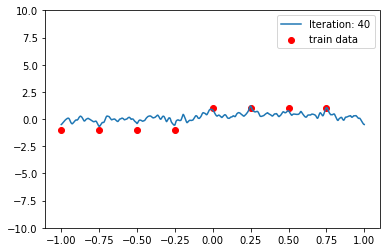

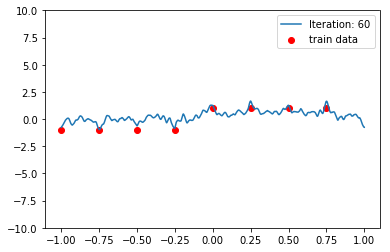

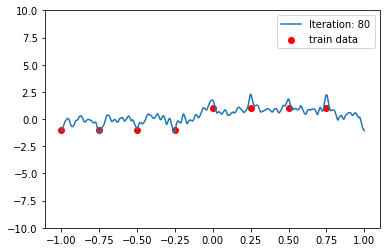

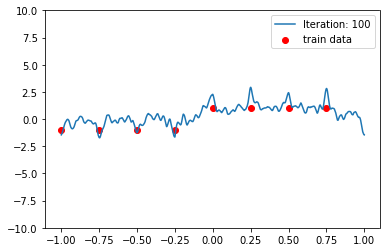

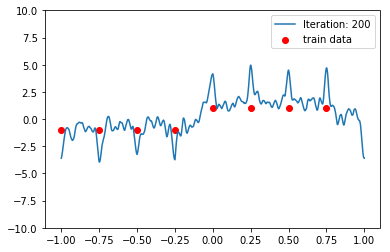

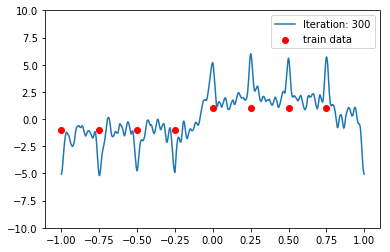

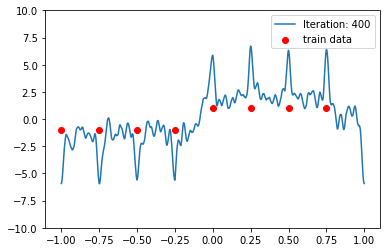

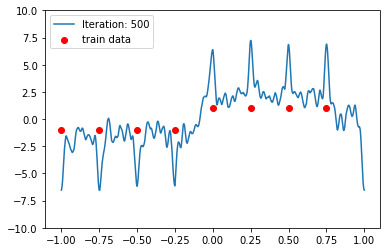

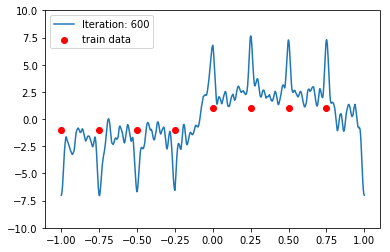

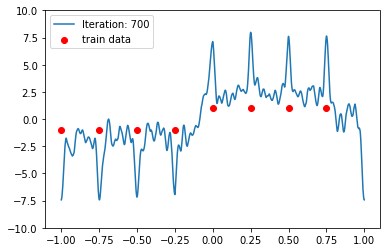

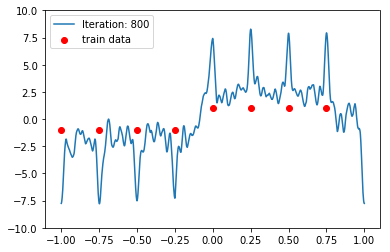

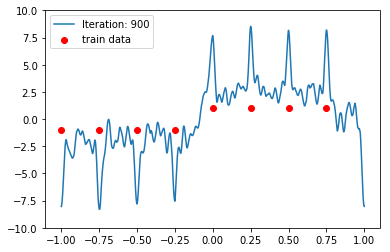

In [30]:
#plt.plot(x_train, y_train_ogi.flatten(),  color = "blue", linewidth=0, marker="D", markersize=5, label = 'Train data', alpha = 0.75 )

for (idx, preds) in enumerate(preds_list_smaller):
    label = "Iteration: " + str(indices[idx])
    plt.scatter(x_train, y_train_ogi, label = 'train data', color = 'red')
    plt.plot(x_test, preds,'-', marker = 'x', markersize = 0, linewidth = 1.5, label = label)
    plt.ylim([-10,10])
    plt.legend()
    plt.show()

# Processing feats and plotting

In [31]:
feats_select = feat_list[-100]

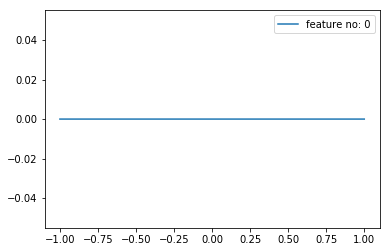

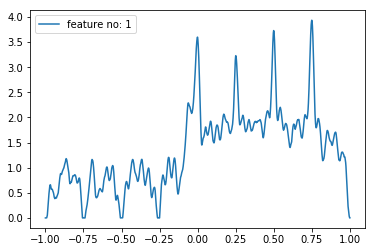

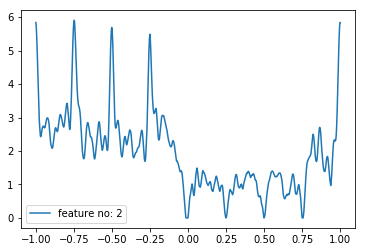

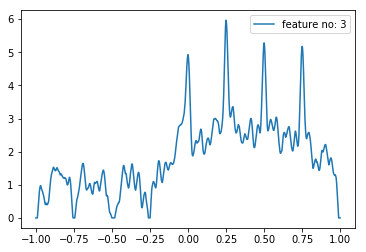

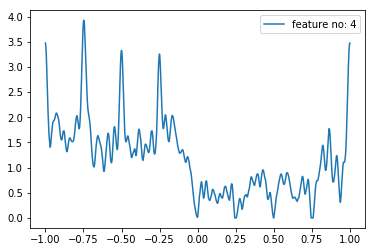

In [32]:
for i in range(5):
    feat_i = feats_select[:, i]
    label = "feature no: " + str(i)
    plt.plot(x_test, feat_i, label = label)
    plt.legend()
    plt.show()